In [249]:
import pandas as pd
import numpy as np
from pandas import DataFrame  
from pandas import Series  
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import glob
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
IP1S2 = pd.read_csv('/data/share/HS_share/Preprocessing_results/Matrix_IP1_S2_drop_nan_drop_dup_C00000004.csv')
IP1S2 = IP1S2[IP1S2['D13'] == 0]
IP1S2.head(5)

,Unnamed: 0,Unnamed: 0.1,D18,D7,D13,D19,D27,D20,D21,PN00002587,...,PN00004785,PN00004786,PN00004787,PN00004788,PN00004789,PN00004790,PN00004791,PN00004792,PN00004793,PN00004794
0,0,37695,C00000004,TP00000002,0,BD00022810,BC00000014,TES00022747,TEC00000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,441848,C00000004,TP00000002,0,BD00022812,BC00000014,TES00022749,TEC00000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,251074,C00000004,TP00000002,0,BD00022838,BC00000014,TES00022775,TEC00000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,142073,C00000004,TP00000002,0,BD00022839,BC00000014,TES00022776,TEC00000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,354765,C00000004,TP00000002,0,BD00022716,BC00000014,TES00022653,TEC00000016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
index = IP1S2.keys().tolist()[9:] # 9: means the feature names

In [4]:
# shuffle
def data_shuffle(data, percent):
    # input: DataFrame, shuffle percentage
    # output: train-test DataFrame
    data = shuffle(data)
    data = data.reset_index(drop=True)
    data_train = data.iloc[0:int(data.shape[0]*percent)]
    data_test = data.iloc[int(data.shape[0]*percent):]
    return data_train, data_test

# data_train, data_test = data_shuffle(IP2S2, 0.8)

## pre-processing

In [122]:
# transform & save the input data (hist)
def save_data(data_train, data_test, index, ifsave = True, save_loc='/home/hs5/results/1st-stage-check/'):
    # input: data_train, data_test (DataFrame after pre-pro), index-list store PN feature
    # output: save_train, save_test
    save_train = {}
    save_test = {}
    for i in index:
        save_train[i] = []
        save_test[i] = []
        train_index, train_count = data_train[i].value_counts().index.to_numpy(), data_train[i].value_counts().to_numpy()
        test_index, test_count = data_test[i].value_counts().index.to_numpy(), data_test[i].value_counts().to_numpy()
        tmp = np.argsort(train_index).tolist()
        train_index.sort()
        train_count = train_count[tmp]
        tmp = np.argsort(test_index).tolist()
        test_index.sort()
        test_count = test_count[tmp]
        save_train[i].append(train_index)
        save_train[i].append(train_count)
        save_test[i].append(test_index)
        save_test[i].append(test_count)
    if ifsave:
        np.save(save_loc + 'save_train.npy', save_train)
        np.save(save_loc + 'save_test.npy', save_test)
    return save_train, save_test
# save_train, save_test = save_data(data_train, data_test, index, ifsave = True)

In [117]:
# shuffle
def data_shuffle(data, percent):
    # input: DataFrame, shuffle percentage
    # output: train-test DataFrame
    data = shuffle(data)
    data = data.reset_index(drop=True)
    data_train = data.iloc[0:int(data.shape[0]*percent)]
    data_test = data.iloc[int(data.shape[0]*percent):]
    return data_train, data_test

# data_train, data_test = data_shuffle(IP2S2, 0.8)

In [102]:
# decode save_data
def decode(save_train, save_test):
    # input: save_train save_test: .npy-pre-pro
    # output: train,test: dict with index (Pn feature) and value (corresponding ndarray)
    train, test = {}, {}
    for i in index:
        L1, L2 = int(np.sum(save_train[i][1])), int(np.sum(save_test[i][1]))
        train[i] = np.zeros(L1)
        test[i] = np.zeros(L2)
        num = 0
        for j in range(save_train[i][1].__len__()):
            train[i][num : num + save_train[i][1][-(j+1)]] = save_train[i][0][-(j+1)]
            num += save_train[i][1][-(j+1)]
        num = 0
        for j in range(save_test[i][1].__len__()):
            test[i][num : num + save_test[i][1][-(j+1)]] = save_test[i][0][-(j+1)]
            num += save_test[i][1][-(j+1)]
    return train, test
# train, test = decode(save_train, save_test)


In [241]:
# judge whether the input data has outlier
def if_outlier(test_count, Num=10):
    # input: test_count: input DataFrame
    # input: Num, division number
    # output: outlier, Boolean, T means has outlier
    # output: records, string, means the distribution
    test_count.sort()
    records = '0'*Num
    test_max, test_min = np.max(test_count), np.min(test_count)
    S = (test_max - test_min)/Num
    
    for i in range(Num):
        tmp_min, tmp_max = test_min + i * S, test_min + (i + 1) * S
        if i == Num - 1:
            tmp1 = test_count[test_count >= tmp_min]
            if tmp1.size != 0:
                records = records[0:i] + '1'
            continue
        tmp1 = test_count[test_count >= tmp_min]
        tmp2 = tmp1[tmp1 < tmp_max]
        if tmp2.size != 0:
            records = records[0:i] + '1' + records[i+1:]
    outlier = records.split('00').__len__() != 1
    return outlier, records

In [242]:
'10100101'.split('00')
'00000000'

['101', '1101']

In [199]:
# compute the PDF of input & old data
def prob_trans(save_train, save_test, data_size, Num = 20):
    # input: save_train, save_test; ndarray, represent the old data and input data
    # input: data_size-represents the size of total data
    # input: Num-division number
    # output: prob_train prob_test; ndarray, represent the discrete PDF of old and input data
    tmp = np.concatenate((save_train, save_test))
    value_max = np.max(tmp)
    value_min = np.min(tmp)
    prob_train, prob_test = np.zeros(Num), np.zeros(Num)
    S = (value_max - value_min) / Num
    for i in range(Num):
        tmp_min = value_min + i * S
        tmp_max = value_min + (i + 1) * S
        if i == Num - 1:
            tmp1 = save_train[save_train >= tmp_min]
            tmp2 = tmp1[tmp1 <= tmp_max]
            prob_train[i] = tmp2.__len__() / data_size[0]
            tmp1= save_test[save_test >= tmp_min]
            tmp2 = tmp1[tmp1 <= tmp_max]
            prob_test[i] = tmp2.__len__() / data_size[1]
            continue
        tmp1 = save_train[save_train >= tmp_min]
        tmp2 = tmp1[tmp1 < tmp_max]
        prob_train[i] = tmp2.__len__() / data_size[0]
        tmp1 = save_test[save_test >= tmp_min]
        tmp2 = tmp1[tmp1 < tmp_max]
        prob_test[i] = tmp2.__len__() / data_size[1]
    return prob_train, prob_test
# prob_train, prob_test = prob_trans(save_train[i], save_test[i], Num = 20)

In [203]:
# compute the outlier judgement and the PDF of train & test
def set_partition(train, test, divide_num=32, Num=10):
    # input: train, test, ndarray
    # input: Num, division number of outlier
    # input: divide_num, division number of total PDF
    outlier, _ = if_outlier(test, Num)
    # judge the outlier
    _, records = if_outlier(np.concatenate((train, test)), Num)
    # non-uniformed PDF computing
    count, value_max, value_min = 0, np.max([train.max(), test.max()]), np.min([train.min(), test.min()])
    S, L_train, L_test = (value_max - value_min) / Num, np.unique(train).__len__(), np.unique(test).__len__()
    prob_results = [[], []]
    for i in records.split('00'):
        if i == '':
            count += 2
            continue
        tmp_min, tmp_max = value_min + count * S, value_min + (count + i.__len__()) * S
        tmp_train, tmp_test = train[train >= tmp_min], test[test >= tmp_min]
        tmp2_train, tmp2_test = tmp_train[tmp_train <= tmp_max], tmp_test[tmp_test <= tmp_max]
        # PDF computing
        tmp = np.max([int(np.ceil(np.unique(tmp2_train).__len__()/L_train*divide_num)), 
                      int(np.ceil(np.unique(tmp2_test).__len__()/L_test)*divide_num)])
        prob_train, prob_test = prob_trans(tmp2_train, tmp2_test, [train.__len__(), test.__len__()], Num = tmp)
        prob_results[0] += prob_train.tolist()
        prob_results[1] += prob_test.tolist()
        count += i.__len__() + 2
    
    return outlier, prob_results

In [233]:
def draw(save_train, save_test):
    value_max = np.max([save_train[0].max(), save_test[0].max()])
    value_min = np.min([save_train[0].min(), save_test[0].min()])
    if value_max == value_min:
        width = 0.1
    else:
        width = np.min([0.35, (value_max - value_min)/save_train[0].__len__()/10]) 
    plt.figure()
    plt.bar(save_train[0]-width, save_train[1]/np.sum(save_train[1]), 2*width, label='Train')
    plt.bar(save_test[0]+width, save_test[1]/np.sum(save_test[1]), 2*width, label='Test')
    plt.legend()
    plt.title('Freq')
    plt.show()

def draw_prob(prob_train, prob_test):
    width = 0.35
    plt.figure()
    plt.bar(np.arange(prob_train.__len__())-width, prob_train, 2*width, label='Train')
    plt.bar(np.arange(prob_train.__len__())+width, prob_test, 2*width, label='Test')
    plt.legend()
    plt.title('Prob')
    plt.show()

In [252]:
# compare the difference between the input and old data
def comparison(data, Iter_num, perc=0.8):
    # input: data: DataFrame after pre-pro
    # input: Iter_num: shuffle number; prec: shuffle percentage

    # start from the first feature
    index = data.keys().tolist()[9:]
    for i in range(Iter_num):
        # shuffle
        data_train, data_test = data_shuffle(data, perc)
        # transform & save hist data
        save_train, save_test = save_data(data_train, data_test, index, ifsave = True)
        train, test = decode(save_train, save_test)
        # loop for each feature
        for j in save_train.keys():
            print(j)
            # judge outlier and compute the PDF of input and old data
            outlier, prob_results = set_partition(train[j], test[j], divide_num=32, Num=8)
            # compute JS-divergence
            js_result = sp.spatial.distance.jensenshannon(prob_results[0], prob_results[1])
            # do ks-test
            cdf_train = [np.sum(prob_results[0][:k]) for k in range(prob_results[0].__len__())]
            cdf_test = [np.sum(prob_results[1][:k]) for k in range(prob_results[1].__len__())]
            ks_result, _ = sp.stats.ks_2samp(train[j], test[j])
            cdf_diff = [cdf_train[i] - cdf_test[i] for i in range(cdf_test.__len__())]
            cdf_diff = np.abs(cdf_diff).max()
            # print distance
            print('Outlier results = %s' % outlier)
            print('Difference of CDFs = %s' % cdf_diff)
            print('Ks-test results = %s' % ks_result)
            print('JS-distance results = %s' % js_result)
            # plot
            draw(save_train[j], save_test[j])
            # interaction
#             break
            if j == 'PN00002650':
                break
#             interaction = input()
            plt.close()


PN00002587
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


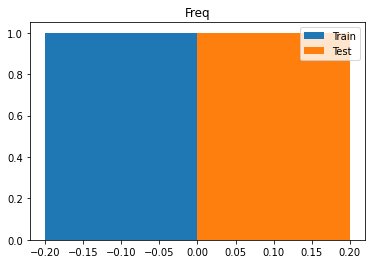

PN00002588
Outlier results = False
Difference of CDFs = 0.12125416204217535
Ks-test results = 0.12125416204217536
JS-distance results = 0.30688599486109375


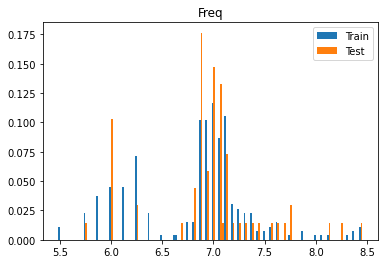

PN00002589
Outlier results = True
Difference of CDFs = 0.12086570477247505
Ks-test results = 0.12086570477247503
JS-distance results = 0.13139357002502375


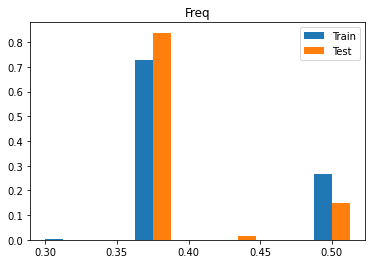

PN00002590
Outlier results = False
Difference of CDFs = 0.11670366259711429
Ks-test results = 0.11670366259711432
JS-distance results = 0.24607993424359154


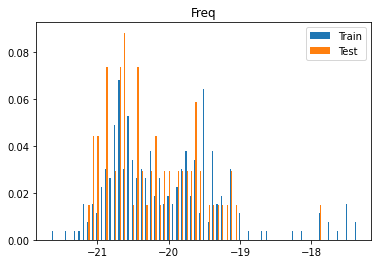

PN00002591
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


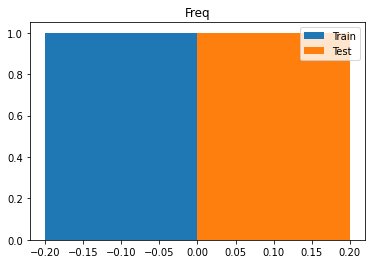

PN00002592
Outlier results = False
Difference of CDFs = 0.0876248612652607
Ks-test results = 0.08840177580466149
JS-distance results = 0.27361677717754257


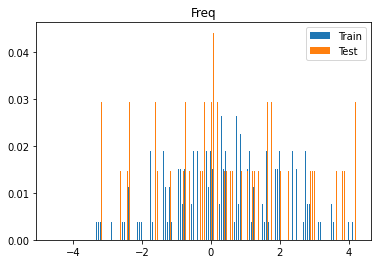

PN00002593
Outlier results = False
Difference of CDFs = 0.07147613762486127
Ks-test results = 0.07996670366259712
JS-distance results = 0.25303447650413746


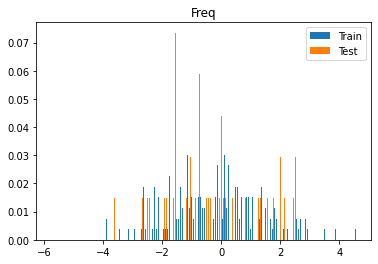

PN00002594
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


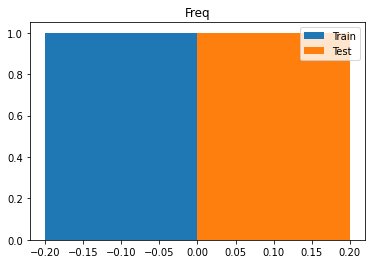

PN00002595
Outlier results = True
Difference of CDFs = 0.12086570477247502
Ks-test results = 0.12086570477247503
JS-distance results = 0.1345159830473322


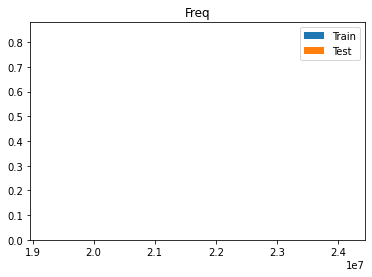

PN00002596
Outlier results = False
Difference of CDFs = 0.09833518312985573
Ks-test results = 0.11054384017758047
JS-distance results = 0.23693117448120357


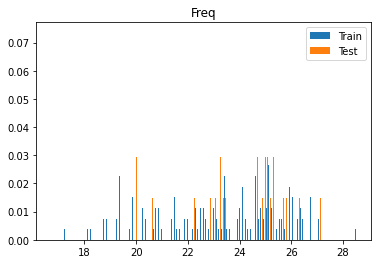

PN00002597
Outlier results = False
Difference of CDFs = 0.08268590455049946
Ks-test results = 0.08274139844617093
JS-distance results = 0.24656168308794577


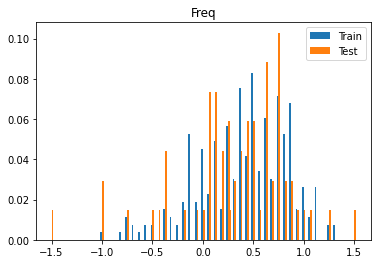

PN00002598
Outlier results = False
Difference of CDFs = 0.13279689234184233
Ks-test results = 0.1327968923418424
JS-distance results = 0.2612139780916471


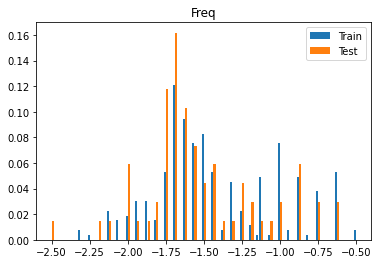

PN00002599
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


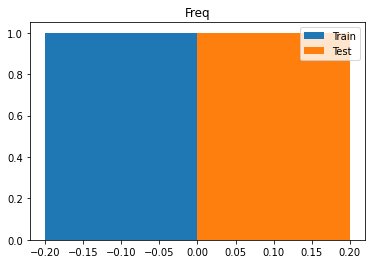

PN00002600
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


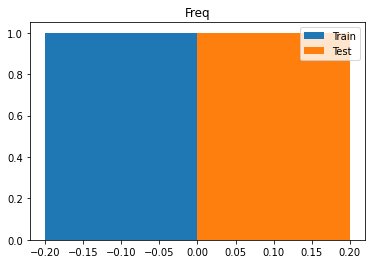

PN00002601
Outlier results = True
Difference of CDFs = 0.15599334073251947
Ks-test results = 0.15599334073251941
JS-distance results = 0.2838674614228033


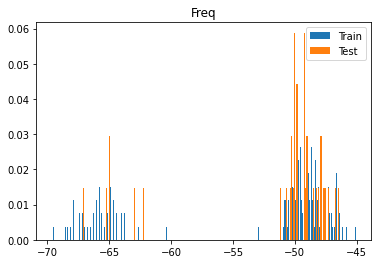

PN00002602
Outlier results = True
Difference of CDFs = 0.14766925638179798
Ks-test results = 0.147669256381798
JS-distance results = 0.3006235340758763


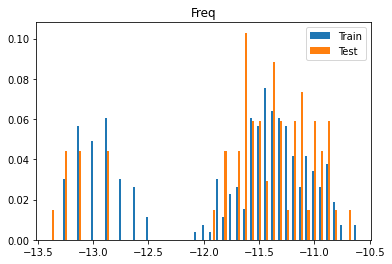

PN00002603
Outlier results = False
Difference of CDFs = 0.17524972253052162
Ks-test results = 0.17524972253052165
JS-distance results = 0.31197915286712635


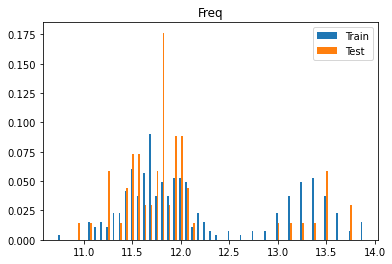

PN00002604
Outlier results = True
Difference of CDFs = 0.1389567147613764
Ks-test results = 0.14544950055493897
JS-distance results = 0.24649805842080036


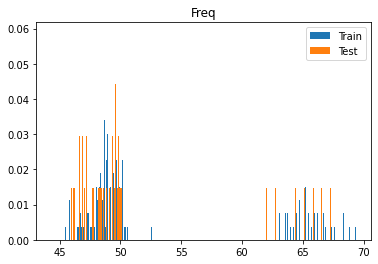

PN00002605
Outlier results = False
Difference of CDFs = 0.12913429522752506
Ks-test results = 0.1351276359600444
JS-distance results = 0.30759734370629205


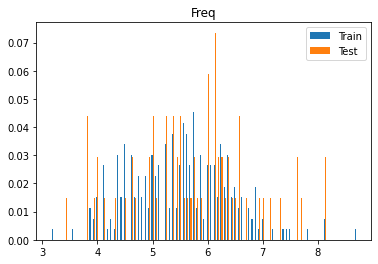

PN00002606
Outlier results = False
Difference of CDFs = 0.1527192008879023
Ks-test results = 0.18995560488346283
JS-distance results = 0.31521069393890944


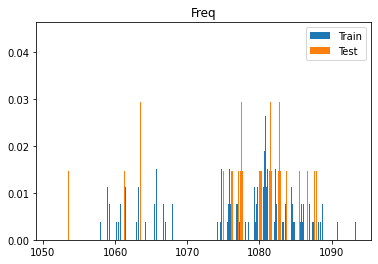

PN00002607
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


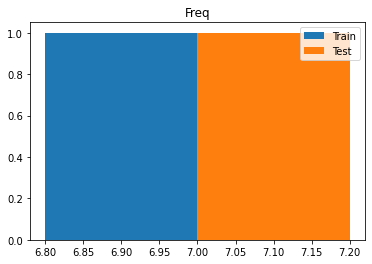

PN00002608
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


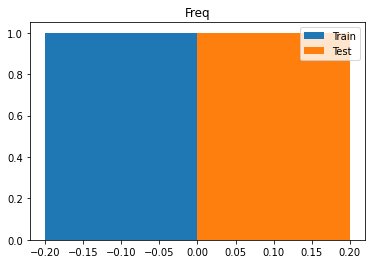

PN00002609
Outlier results = False
Difference of CDFs = 0.059933407325194255
Ks-test results = 0.09428412874583796
JS-distance results = 0.23374833665037495


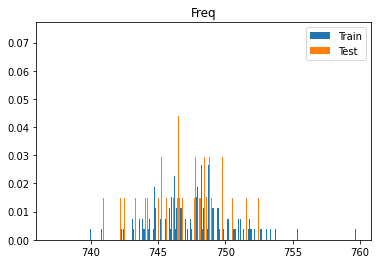

PN00002610
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


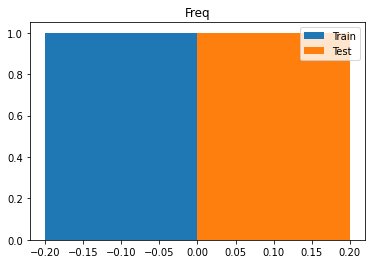

PN00002611
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


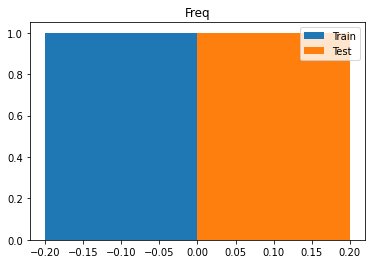

PN00002612
Outlier results = False
Difference of CDFs = 0.1262486126526082
Ks-test results = 0.1488901220865705
JS-distance results = 0.3076507597316041


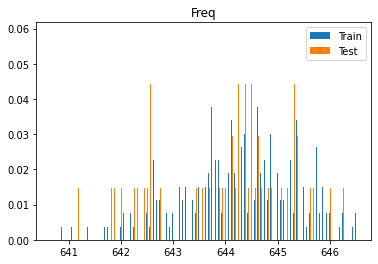

PN00002613
Outlier results = False
Difference of CDFs = 0.10837957824639291
Ks-test results = 0.1113762486126526
JS-distance results = 0.3171442841385203


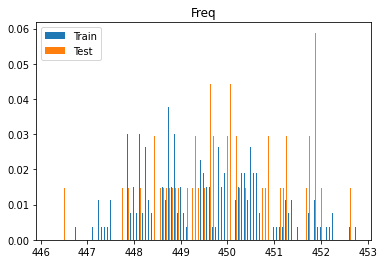

PN00002614
Outlier results = False
Difference of CDFs = 0.13473917869034413
Ks-test results = 0.14267480577136515
JS-distance results = 0.3474955195500234


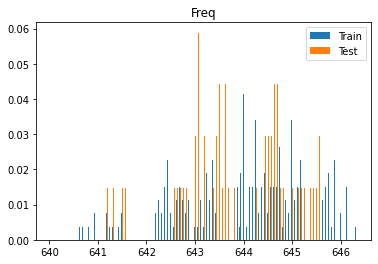

PN00002615
Outlier results = False
Difference of CDFs = 0.11548279689234181
Ks-test results = 0.11614872364039956
JS-distance results = 0.21295587808096678


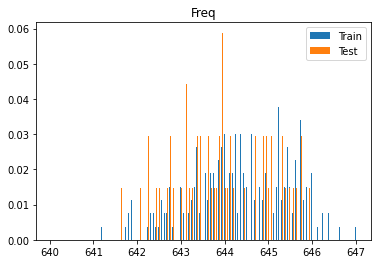

PN00002616
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


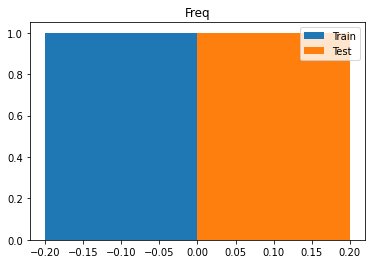

PN00002617
Outlier results = True
Difference of CDFs = 0.1397336293007769
Ks-test results = 0.1760266370699223
JS-distance results = 0.21245983698772045


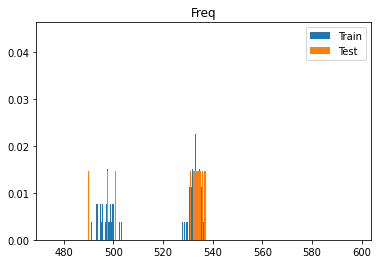

PN00002618
Outlier results = True
Difference of CDFs = 0.12918978912319642
Ks-test results = 0.1334628190899001
JS-distance results = 0.2848147037076049


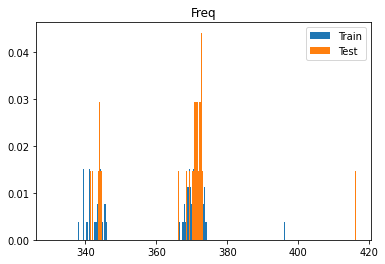

PN00002619
Outlier results = True
Difference of CDFs = 0.12086570477247502
Ks-test results = 0.14012208657047726
JS-distance results = 0.1931903937673713


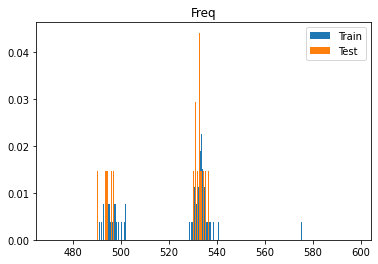

PN00002620
Outlier results = True
Difference of CDFs = 0.12086570477247502
Ks-test results = 0.14051054384017758
JS-distance results = 0.17124187453255138


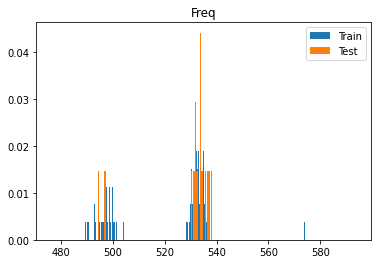

PN00002621
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


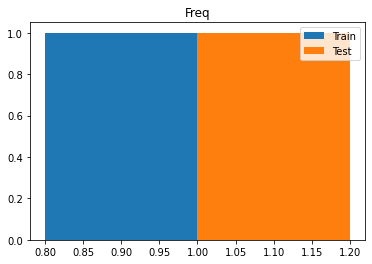

PN00002622
Outlier results = False
Difference of CDFs = 0.10993340732519408
Ks-test results = 0.10993340732519423
JS-distance results = 0.2913177449842514


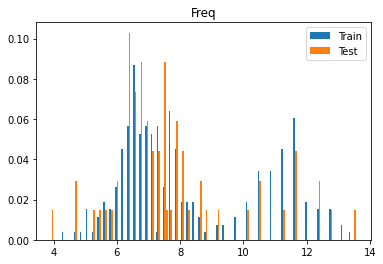

PN00002623
Outlier results = True
Difference of CDFs = 0.12463928967813548
Ks-test results = 0.12463928967813541
JS-distance results = 0.3509130657470331


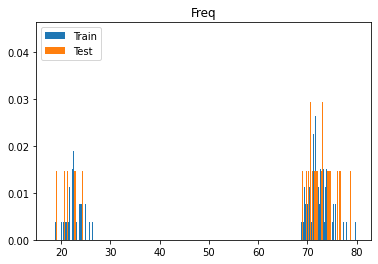

PN00002624
Outlier results = True
Difference of CDFs = 0.034461709211986685
Ks-test results = 0.03446170921198668
JS-distance results = 0.26457207057028154


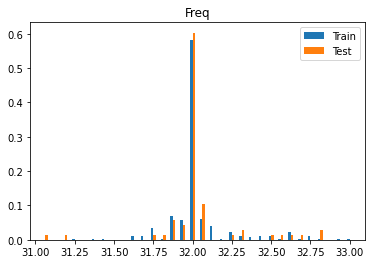

PN00002625
Outlier results = True
Difference of CDFs = 0.040066592674805765
Ks-test results = 0.07946725860155383
JS-distance results = 0.12050826868740334


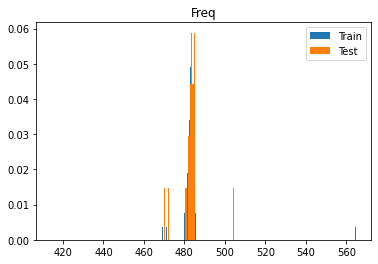

PN00002626
Outlier results = True
Difference of CDFs = 0.1280244173140953
Ks-test results = 0.13179800221975582
JS-distance results = 0.1933892046032825


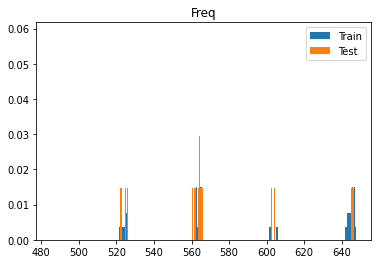

PN00002627
Outlier results = True
Difference of CDFs = 0.046781354051054325
Ks-test results = 0.07502774694783573
JS-distance results = 0.11518822389903334


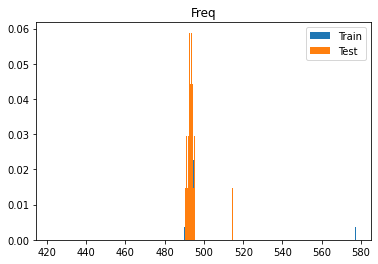

PN00002628
Outlier results = True
Difference of CDFs = 0.08596004439511656
Ks-test results = 0.097669256381798
JS-distance results = 0.18466332833060534


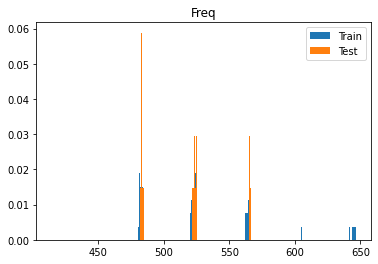

PN00002629
Outlier results = True
Difference of CDFs = 0.12991120976692572
Ks-test results = 0.12991120976692563
JS-distance results = 0.17086348924410924


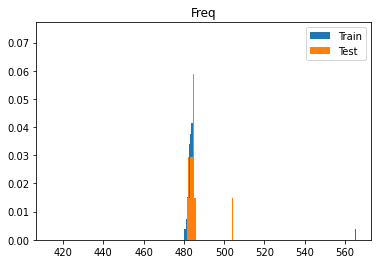

PN00002630
Outlier results = True
Difference of CDFs = 0.10277469478357382
Ks-test results = 0.1027746947835738
JS-distance results = 0.1930942767019985


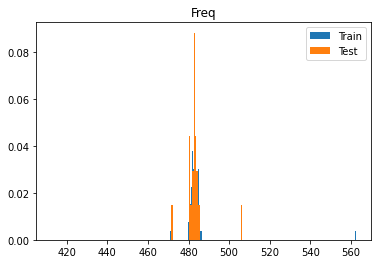

PN00002631
Outlier results = True
Difference of CDFs = 0.12463928967813542
Ks-test results = 0.12463928967813541
JS-distance results = 0.1345159830473322


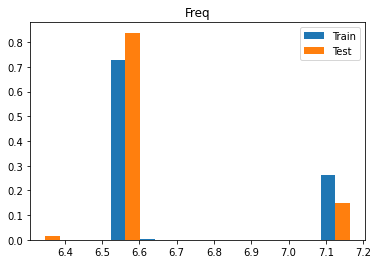

PN00002632
Outlier results = True
Difference of CDFs = 0.11709211986681464
Ks-test results = 0.11709211986681466
JS-distance results = 0.13451598304733223


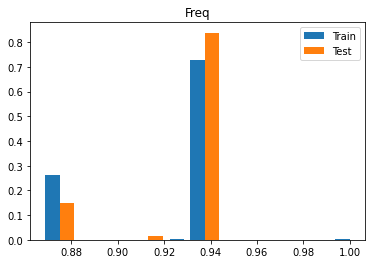

PN00002633
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


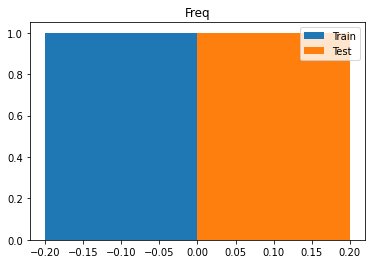

PN00002634
Outlier results = False
Difference of CDFs = 0.1428412874583796
Ks-test results = 0.14284128745837957
JS-distance results = 0.26650120511481834


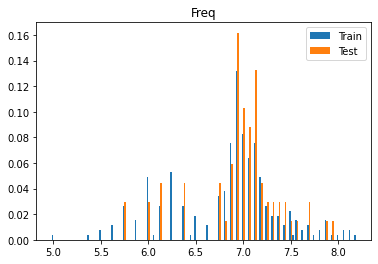

PN00002635
Outlier results = True
Difference of CDFs = 0.10615982241953392
Ks-test results = 0.10615982241953385
JS-distance results = 0.13451598304733223


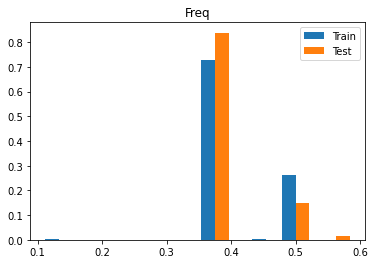

PN00002636
Outlier results = False
Difference of CDFs = 0.12369589345172027
Ks-test results = 0.13590455049944505
JS-distance results = 0.32498588218796975


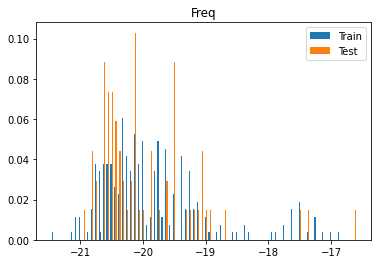

PN00002637
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


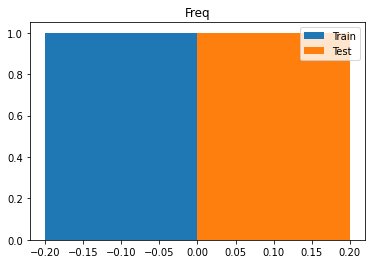

PN00002638
Outlier results = False
Difference of CDFs = 0.05954495005549382
Ks-test results = 0.0716426193118757
JS-distance results = 0.23213686940131467


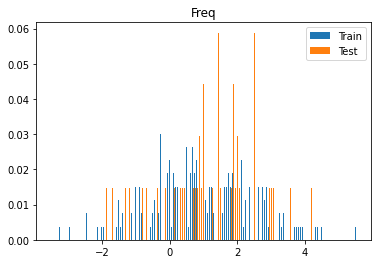

PN00002639
Outlier results = False
Difference of CDFs = 0.059156492785793546
Ks-test results = 0.06748057713651498
JS-distance results = 0.2808086218183948


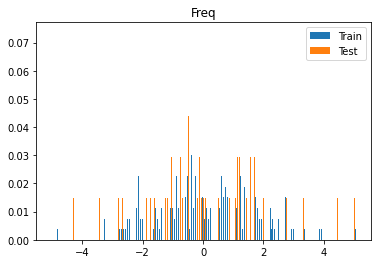

PN00002640
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


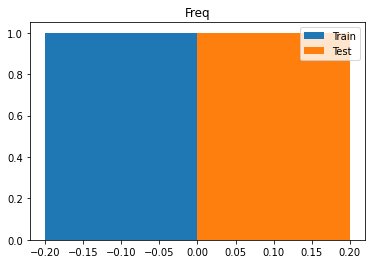

PN00002641
Outlier results = True
Difference of CDFs = 0.12086570477247502
Ks-test results = 0.12086570477247503
JS-distance results = 0.11583445381494825


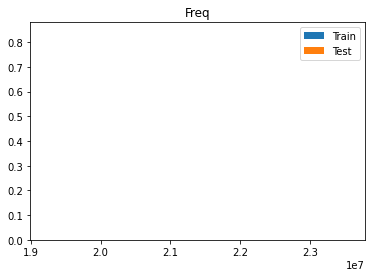

PN00002642
Outlier results = False
Difference of CDFs = 0.1900665926748059
Ks-test results = 0.1918978912319645
JS-distance results = 0.3502501382045799


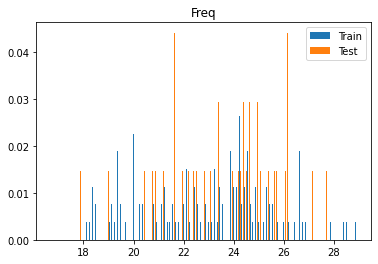

PN00002643
Outlier results = False
Difference of CDFs = 0.06664816870144286
Ks-test results = 0.06664816870144284
JS-distance results = 0.2781811595169624


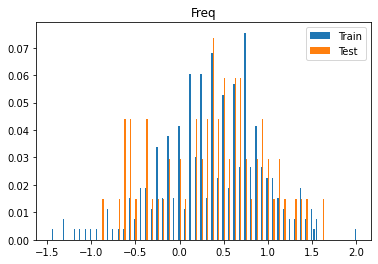

PN00002644
Outlier results = False
Difference of CDFs = 0.11897891231964486
Ks-test results = 0.11897891231964484
JS-distance results = 0.2318989566575628


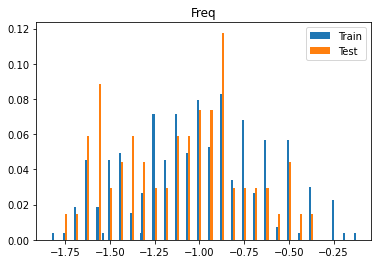

PN00002645
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


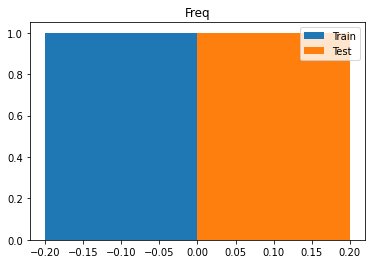

PN00002646
Outlier results = True
Difference of CDFs = 0.0
Ks-test results = 0.0
JS-distance results = 0.0


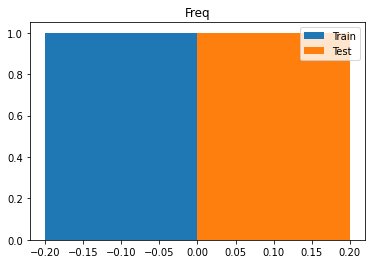

PN00002647
Outlier results = True
Difference of CDFs = 0.21193118756936735
Ks-test results = 0.21193118756936738
JS-distance results = 0.3440025016815131


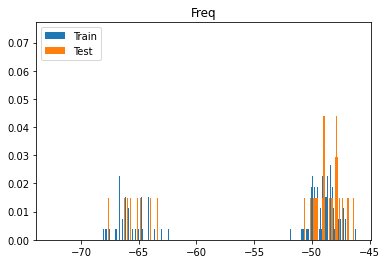

PN00002648
Outlier results = False
Difference of CDFs = 0.1315205327413984
Ks-test results = 0.13152053274139844
JS-distance results = 0.27332629577336265


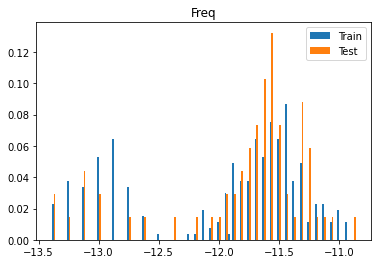

PN00002649
Outlier results = False
Difference of CDFs = 0.12086570477247482
Ks-test results = 0.12463928967813541
JS-distance results = 0.29960463639455764


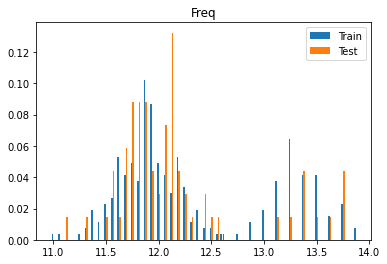

PN00002650
Outlier results = True
Difference of CDFs = 0.1741953385127636
Ks-test results = 0.18967813540510545
JS-distance results = 0.36964236753589963


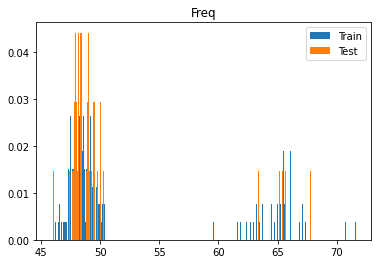

In [253]:
# main_func
# data: DataFrame, Iter_num: iteration number
data = IP1S2
Iter_num = 1
comparison(data, Iter_num)

In [245]:
type(IP1S2)

pandas.core.frame.DataFrame